In [ ]:
import copy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import squidpy as sq


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/LCL/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/LCL/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  Fil

### Data Loading

In [ ]:
data_dir = "/Users/apple/Desktop/QBS146_Bioinfo_I/final_project/dataset"
adata = ad.read_h5ad(data_dir+'/h5ad/2024_xenium_breast_tTMA1.h5ad')

In [3]:
adata.shape

(342704, 541)

In [4]:
adata.obs.columns

Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'x', 'y', 'core', 'tissue_type'],
      dtype='object')

In [5]:
print("n_cells:", adata.n_obs)
print("n_genes:", adata.n_vars)
print("n_cores:", adata.obs["core"].nunique())
print(adata.obs["tissue_type"].value_counts())

n_cells: 342704
n_genes: 541
n_cores: 145
tissue_type
OvC           51209
Tonsil        48990
CRC           45526
NSCLC         42979
BlC           39690
HNSCC         36232
BrC           23758
Melanoma      22520
Lymph node    21778
MARKER        10022
Name: count, dtype: int64


In [7]:
adata.obsm.keys

<bound method Mapping.keys of AxisArrays with keys: spatial>

### Visualization of TMA data

#### All cores

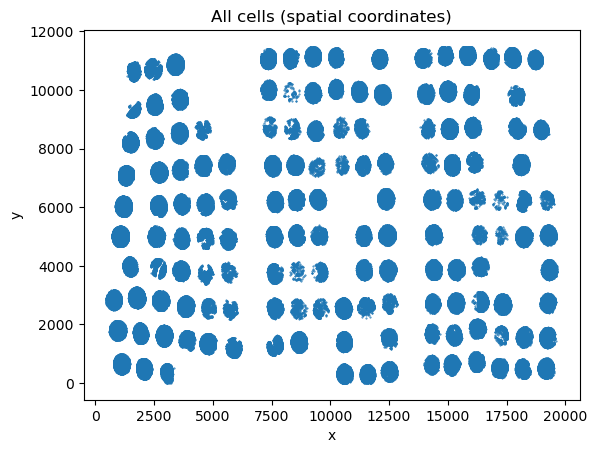

In [ ]:
xy = adata.obsm["spatial"]
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=0.2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("All cells (spatial coordinates)")
plt.show()

#### Top 12 cores

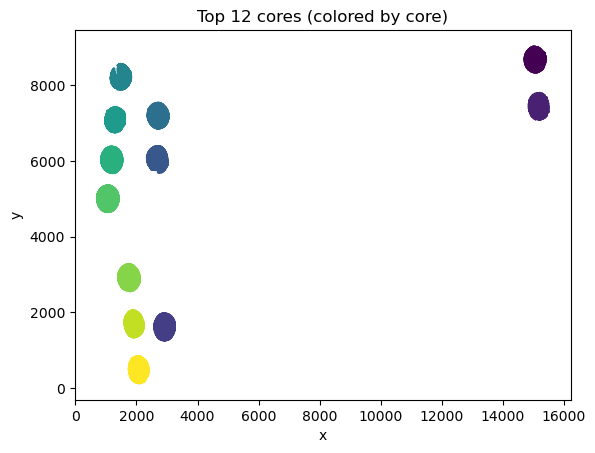

In [9]:
core_counts = adata.obs["core"].value_counts()
top_cores = core_counts.head(12).index

sub = adata[adata.obs["core"].isin(top_cores)].copy()
xy = sub.obsm["spatial"]

plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=1, c=pd.Categorical(sub.obs["core"]).codes)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Top 12 cores (colored by core)")
plt.show()

#### Top 1 cores (Core 168)

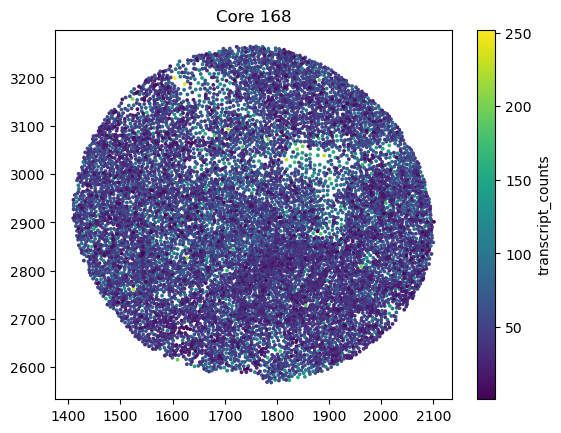

In [ ]:
core_id = adata.obs["core"].value_counts().index[0]
ad = adata[adata.obs["core"] == core_id]

xy = ad.obsm["spatial"]

plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=3, c=ad.obs["transcript_counts"])
plt.colorbar(label="transcript_counts")
plt.title(f"Core {core_id}")
plt.show()

#### UMAP of gene expression of the top 3 cores

/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


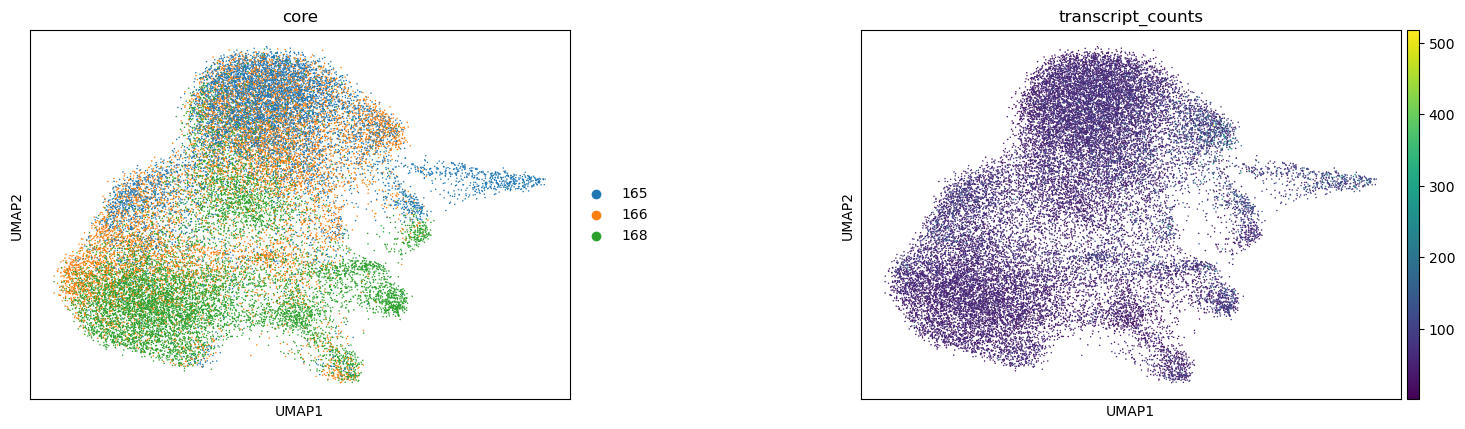

In [ ]:
ad_small = adata[adata.obs["core"].isin(adata.obs["core"].value_counts().head(3).index)].copy()
sc.pp.normalize_total(ad_small)
sc.pp.log1p(ad_small)
sc.pp.highly_variable_genes(ad_small, n_top_genes=2000)
ad_small = ad_small[:, ad_small.var["highly_variable"]].copy()
sc.pp.pca(ad_small)
sc.pp.neighbors(ad_small)
sc.tl.umap(ad_small)

sc.pl.umap(ad_small, color=["core", "transcript_counts"], wspace=0.4)

### Moran's I and Geary's C simple analysis of the largest core

In [11]:
core_id = adata.obs["core"].value_counts().index[0]
ad = adata[adata.obs["core"] == core_id].copy()

In [ ]:
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)

/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [ ]:
mean_expr = np.array(ad.X.mean(axis=0)).flatten()
top_genes = ad.var_names[np.argsort(mean_expr)[-5:]]
top_genes

Index(['IL7R', 'CD3E', 'CXCL12', 'TRAC', 'PTPRC'], dtype='object')

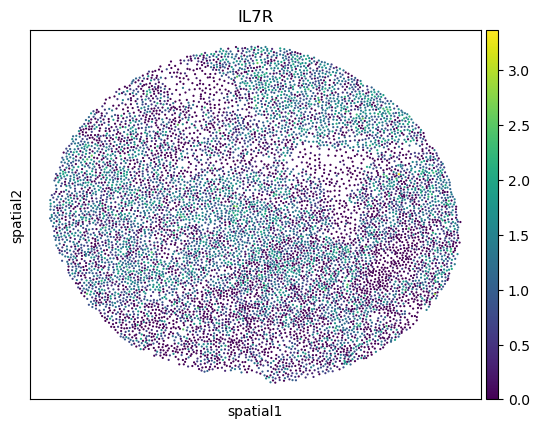

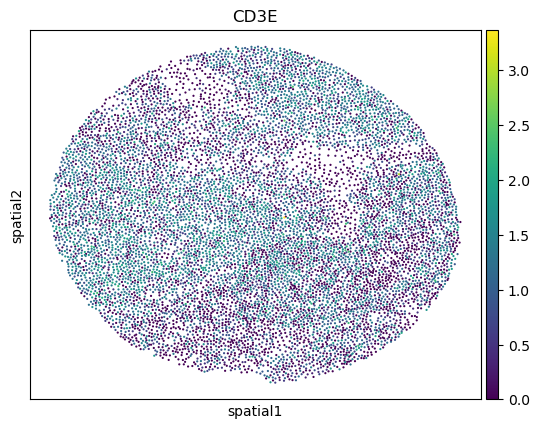

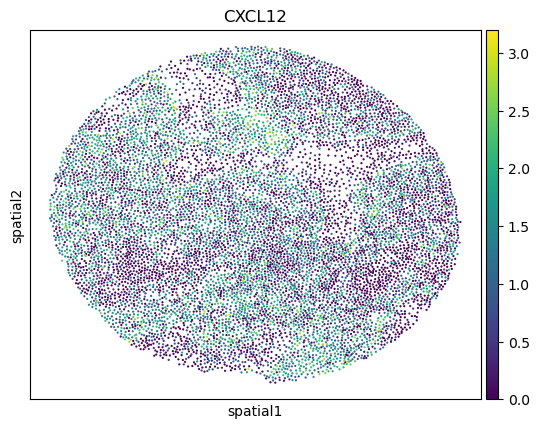

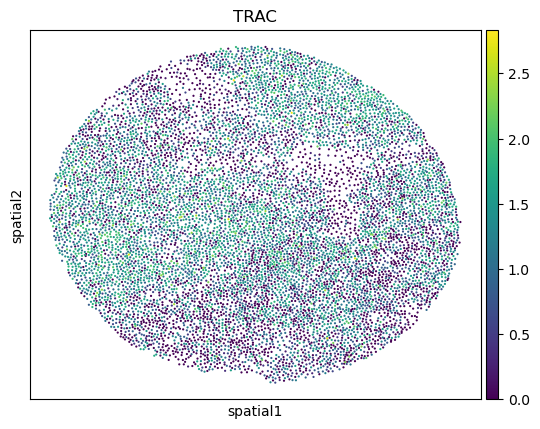

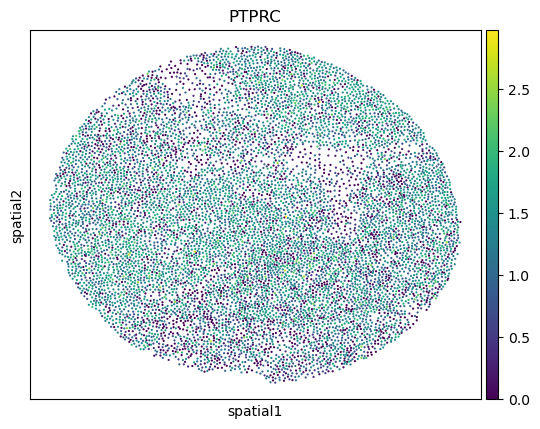

In [ ]:
for g in top_genes:
    sc.pl.embedding(ad, basis="spatial", color=g, size=10)

#### Moran's I

In [19]:
sq.gr.spatial_neighbors(
    ad,
    coord_type="generic",
    spatial_key="spatial"
)

In [20]:
sq.gr.spatial_autocorr(
    ad,
    mode="moran",
    genes=ad.var_names,
    n_perms=500  # use 100 first if slow
)

moran_df = ad.uns["moranI"]
moran_df.head()

/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 12 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()
  0%|          | 0/500 [00:00<?, ?/s]/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 12 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()
/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with '

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
LYZ,0.548262,0.0,0.000033,0.0,0.001996,0.000064,NaN,NaN,0.005683
MRC1,0.356601,0.0,0.000033,0.0,0.001996,0.000046,NaN,NaN,0.005683
CXCL12,0.330578,0.0,0.000033,0.0,0.001996,0.000045,NaN,NaN,0.005683
AQP1,0.280823,0.0,0.000033,0.0,0.001996,0.000031,NaN,NaN,0.005683
TRAC,0.216519,0.0,0.000033,0.0,0.001996,0.000036,NaN,NaN,0.005683


In [ ]:
moran_df.sort_values("I", ascending=False).head(20)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
LYZ,0.548262,0.0,0.000033,0.0,0.001996,0.000064,NaN,NaN,0.005683
MRC1,0.356601,0.0,0.000033,0.0,0.001996,0.000046,NaN,NaN,0.005683
CXCL12,0.330578,0.0,0.000033,0.0,0.001996,0.000045,NaN,NaN,0.005683
AQP1,0.280823,0.0,0.000033,0.0,0.001996,0.000031,NaN,NaN,0.005683
TRAC,0.216519,0.0,0.000033,0.0,0.001996,0.000036,NaN,NaN,0.005683
VWF,0.212738,0.0,0.000033,0.0,0.001996,0.000027,NaN,NaN,0.005683
FCER1G,0.204917,0.0,0.000033,0.0,0.001996,0.000033,NaN,NaN,0.005683
MS4A1,0.201065,0.0,0.000033,0.0,0.001996,0.000031,NaN,NaN,0.005683
CD3E,0.193910,0.0,0.000033,0.0,0.001996,0.000035,NaN,NaN,0.005683
IL7R,0.189283,0.0,0.000033,0.0,0.001996,0.000032,NaN,NaN,0.005683


#### Geary's C

In [22]:
sq.gr.spatial_autocorr(
    ad,
    mode="geary",
    genes=ad.var_names,
    n_perms=500
)

geary_df = ad.uns["gearyC"]
geary_df.head()

/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/scanpy/metrics/_gearys_c.py:107: UserWarning: 12 variables were constant, will return nan for these.
  return _GearysC(graph, vals)()
  0%|          | 0/500 [00:00<?, ?/s]/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/scanpy/metrics/_gearys_c.py:107: UserWarning: 12 variables were constant, will return nan for these.
  return _GearysC(graph, vals)()
/opt/anaconda3/envs/LCL/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with '

,C,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
LYZ,0.444422,0.0,0.000033,0.000000,0.001996,5.621725e-05,NaN,NaN,0.005713
MRC1,0.634311,0.0,0.000033,0.000000,0.001996,4.217439e-05,NaN,NaN,0.005713
CXCL12,0.671671,0.0,0.000033,0.000000,0.001996,3.790818e-05,NaN,NaN,0.005713
AQP1,0.690686,0.0,0.000033,0.000000,0.001996,3.150770e-05,NaN,NaN,0.005713
UnassignedCodeword_0069,0.750000,0.0,0.000033,0.151011,0.049900,3.092800e-27,NaN,NaN,0.110349


In [23]:
geary_df.sort_values("C", ascending=True).head(20)

,C,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
LYZ,0.444422,0.000000e+00,0.000033,0.000000e+00,0.001996,5.621725e-05,NaN,NaN,0.005713
MRC1,0.634311,0.000000e+00,0.000033,0.000000e+00,0.001996,4.217439e-05,NaN,NaN,0.005713
CXCL12,0.671671,0.000000e+00,0.000033,0.000000e+00,0.001996,3.790818e-05,NaN,NaN,0.005713
AQP1,0.690686,0.000000e+00,0.000033,0.000000e+00,0.001996,3.150770e-05,NaN,NaN,0.005713
UnassignedCodeword_0069,0.750000,0.000000e+00,0.000033,1.510109e-01,0.049900,3.092800e-27,NaN,NaN,0.110349
VWF,0.760548,0.000000e+00,0.000033,0.000000e+00,0.001996,2.482709e-05,NaN,NaN,0.005713
UnassignedCodeword_0387,0.775064,0.000000e+00,0.000033,4.760102e-01,0.053892,1.420769e-06,NaN,NaN,0.110349
TRAC,0.784149,2.278376e-308,0.000033,3.506330e-294,0.001996,3.497044e-05,NaN,NaN,0.005713
UnassignedCodeword_0352,0.788348,1.388821e-296,0.000033,1.406639e-01,0.049900,3.402098e-27,NaN,NaN,0.110349
FCER1G,0.791358,2.824572e-288,0.000033,1.777453e-280,0.001996,3.289863e-05,NaN,NaN,0.005713


#### Jaccard 

In [24]:
topk = 100

moran_top = moran_df.sort_values("I", ascending=False).head(topk).index
geary_top = geary_df.sort_values("C", ascending=True).head(topk).index

jaccard = len(set(moran_top) & set(geary_top)) / len(set(moran_top) | set(geary_top))
jaccard

0.4925373134328358